In [1]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
import pandas as pd
from Bio.Seq import Seq
from typing import List, Dict, Union



def open_gff3_files(path:str= '') -> List[List[str]]:
    '''
    Opens and reads a GFF3 file and returns its contents as a list of lists.

    Parameters:
    -----------
    path: str
        The path to the GFF3 file.

    Returns:
    --------
    List[List[str]]
        A list of lists containing the contents of the GFF3 file.
    '''
    with open(path, 'r') as infile:
        LINES = []
        for line in infile:
            LINES.append(line[:].split('\t'))
        LINES = LINES[1:]
    
    return LINES



def tidy_up_gff(lst_of_gff:list) -> list:
    """
    This function takes a list of GFF lines and returns a list of dictionaries,
    with each dictionary containing information on the signal peptides in the GFF file.
    
    Parameters:
    lst_of_gff (list): A list of GFF lines.
    
    Returns:
    list_of_peptides (list): A list of dictionaries, with each dictionary containing information on the signal peptides in the GFF file.
    """
    signal_peptides = {}
    list_of_peptides = []

    for peptide in lst_of_gff:
        signal_peptides['gene'] = peptide[0][:19]
        signal_peptides['start_pos'] = int(peptide[3])-1
        signal_peptides['end_pos']= int(peptide[4])-1
        signal_peptides['signal_peptide_likelyhood']= peptide[5]
        list_of_peptides.append(signal_peptides)
        signal_peptides = {'gene':'', 'start_pos':'', 'end_pos':'','signal_peptide_likelyhood': '' }

    return list_of_peptides




def dict_of_signal_peptides(path: str = '') -> List[Dict[str, Union[str, int]]]:
    """
    Given a path to a GFF3 file, returns a list of dictionaries with information on signal peptides.

    Args:
        path (str): Path to the GFF3 file. Default is an empty string.

    Returns:
        list: A list of dictionaries where each dictionary contains the following keys:
            - 'gene' (str): Gene name of the signal peptide.
            - 'start_pos' (int): Start position of the signal peptide in the protein sequence.
            - 'end_pos' (int): End position of the signal peptide in the protein sequence.
            - 'signal_peptide_likelyhood' (str): The likelihood of the sequence being a signal peptide.
    """
    gff = open_gff3_files(path)
    dict_of_signal_peptides = tidy_up_gff(gff)
    return dict_of_signal_peptides


def read_gff_to_pd(path:str= '') -> pd.DataFrame:
    """
    Reads a GFF3 file and returns a pandas DataFrame with columns 'gene', 'start_pos', 'end_pos', 
    and 'signal_peptide_likelyhood'.
    
    Parameters:
    -----------
    path : str
        The path to the GFF3 file.
        
    Returns:
    --------
    df : pandas.DataFrame
        A DataFrame with columns 'gene', 'start_pos', 'end_pos', and 'signal_peptide_likelyhood'.
    """
    
    gff = open_gff3_files(path)
    dict_of_signal_peptides = tidy_up_gff(gff)
    df = pd.DataFrame.from_records(dict_of_signal_peptides)
    
    return df



def get_signal_peptides_cross_ref_with_genome(list_of_peptides: List[dict], all_proteins: List[SeqRecord]) -> List[SeqRecord]:
    """
    Extracts the protein sequence that corresponds to each predicted signal peptide sequence from the input list
    of peptides and matches the signal peptide to its corresponding protein sequence in the input list of 
    protein sequences.
    
    Parameters
    ----------
    list_of_peptides : list
        A list of dictionaries containing information about predicted signal peptide sequences, including gene name, 
        start and end positions, and the signal peptide likelihood score.
    all_proteins : list
        A list of SeqRecord objects containing protein sequences.
    
    Returns
    -------
    list
        A list of SeqRecord objects that correspond to the input predicted signal peptide sequences, including 
        protein sequence, ID, name, and a description indicating that the sequence corresponds to a predicted 
        signal peptide.
    """
    signal_peptide_seqs = []

    for signal_peptide in list_of_peptides:
        for seqrecord in all_proteins:
            if signal_peptide['gene'] in seqrecord.id:             
                seq = SeqRecord(
                    Seq(seqrecord.seq[signal_peptide['start_pos']:signal_peptide['end_pos']]), 
                    id=seqrecord.id,
                    name=seqrecord.name,
                    description="signal_peptide predicted by signalP")

                signal_peptide_seqs.append(seq)

    return signal_peptide_seqs


def add_dunder_tail(peptide:str , max_lenght:int=22 ): 
    '''Adds a tail if a peptide is shorter than the specified max_len.
    '''
    if len(peptide) < max_lenght: 
        difference = max_lenght - len(peptide)
        sequence = peptide + ('-'*difference)
    else: 
        sequence = peptide
        
    return sequence     


# 00_Data_processing

## Introduction
The objective of this project is to analyze the signal peptides of the A.oryzae genome. The first step is to download the genome and partition it into 5000 bits. These bits will then be uploaded to SignalP, a tool for predicting signal peptides. The program will retrieve the signal peptides from SignalP and perform an analysis of different regions. Finally, the project will create position weight matrices (PWM) for all peptides, median peptides, and peptides found from proteomics data.

### Objective: 


- Download the A.oryzae genome
- Partition the genome into 5000 bits
- Upload the partitioned genome to SignalP
- Retrieve signal peptides from the SignalP analysis
- Analyze different regions of the signal peptides
- Create position weight matrices (PWM) for all peptides, median peptides, and peptides found from proteomics data.

In [2]:
from teemi.design.fetch_sequences import read_fasta_files

In [3]:
proteins = read_fasta_files('../data/00_All_proteins_and_partitions_Aoryzae_and_/FungiDB-59_AoryzaeRIB40_AnnotatedProteins.fasta'  )

In [4]:
len(proteins)

12090

### Partitioning the proteins into 5000 long fasta files

In [5]:
partition1 = proteins[0:5000]
len(partition1)

5000

In [6]:
partition2 = proteins[5000:10000]
len(partition2)

5000

In [7]:
partition3 = proteins[10000:]
len(partition3)


2090

In [8]:
all_partitions = [[partition1]+[partition2]+[partition3]]
all_partitions = [partition1+partition2+partition3]

len(all_partitions)

1

In [9]:
with open(f"../data/00_All_proteins_and_partitions_Aoryzae_and_/partition1.fasta", "w") as output_handle:
    SeqIO.write(partition1, output_handle, "fasta")
with open(f"../data/00_All_proteins_and_partitions_Aoryzae_and_/partition2.fasta", "w") as output_handle:
    SeqIO.write(partition2, output_handle, "fasta")
with open(f"../data/00_All_proteins_and_partitions_Aoryzae_and_/partition3.fasta", "w") as output_handle:
    SeqIO.write(partition3, output_handle, "fasta")

These partitions have been sent to SignalP and run on their servers. 

### Examining SignalP output


In signalP with the following parameters were used: 

Organism : Eukarya
Output format: Short output (no figures)
Model mode: Slow
 


Output from SignalP are shown below : gff files are just a text file. So we can parse it like a normal text file:

In [10]:
partition1_signal_peptides = read_gff_to_pd('../data/01_SignalP_output/Partition1/output.gff3')
partition2_signal_peptides = read_gff_to_pd('../data/01_SignalP_output/Partition2 /output (1).gff3')
partition3_signal_peptides = read_gff_to_pd('../data/01_SignalP_output/Partition3/output (2).gff3')

all_signal_peptides_df = pd.concat([partition1_signal_peptides, partition2_signal_peptides, partition3_signal_peptides])
all_signal_peptides_df

,gene,start_pos,end_pos,signal_peptide_likelyhood
0,AO090005000016-T-p1,0,23,0.99980325
1,AO090005000029-T-p1,0,23,0.99983543
2,AO090005000042-T-p1,0,23,0.99984324
3,AO090005000053-T-p1,0,41,0.8548089
4,AO090005000059-T-p1,0,18,0.9998212
...,...,...,...,...
196,AO090103000483-T-p1,0,19,0.83310604
197,AO090103000487-T-p1,0,19,0.99971014
198,AO090103000493-T-p1,0,17,0.99979144
199,AO090701000994-T-p1,0,18,0.99984515


We got 1061 signal peptides predicted from the A.oryzae genome. Let's add them together make them into a list of dicts.

In [11]:
partition1_signal_peptides = dict_of_signal_peptides('../data/01_SignalP_output/Partition1/output.gff3')
partition2_signal_peptides = dict_of_signal_peptides('../data/01_SignalP_output/Partition2 /output (1).gff3')
partition3_signal_peptides = dict_of_signal_peptides('../data/01_SignalP_output/Partition3/output (2).gff3')
all_signal_peptides = partition1_signal_peptides +partition2_signal_peptides+ partition3_signal_peptides

In [12]:
all_signal_peptides[:5]

[{'gene': 'AO090005000016-T-p1',
  'start_pos': 0,
  'end_pos': 23,
  'signal_peptide_likelyhood': '0.99980325'},
 {'gene': 'AO090005000029-T-p1',
  'start_pos': 0,
  'end_pos': 23,
  'signal_peptide_likelyhood': '0.99983543'},
 {'gene': 'AO090005000042-T-p1',
  'start_pos': 0,
  'end_pos': 23,
  'signal_peptide_likelyhood': '0.99984324'},
 {'gene': 'AO090005000053-T-p1',
  'start_pos': 0,
  'end_pos': 41,
  'signal_peptide_likelyhood': '0.8548089'},
 {'gene': 'AO090005000059-T-p1',
  'start_pos': 0,
  'end_pos': 18,
  'signal_peptide_likelyhood': '0.9998212'}]

### Cross reference with the genome to extract the signal peptides

The function below goes through the genome and if it finds a genome annotation that fits with the signal peptides we got from signalP it takes the sequence and saves it as Seqrecord objects: 
    

In [13]:
pure_signal_peptide = get_signal_peptides_cross_ref_with_genome(all_signal_peptides, proteins)
print(pure_signal_peptide[0])
print(len(pure_signal_peptide[0]))

ID: AO090005000016-T-p1
Name: AO090005000016-T-p1
Description: signal_peptide predicted by signalP
Number of features: 0
Seq('MAPSHSFMLFLSVICTHLCSLVV')
23


In [14]:
pure_signal_peptide[0].format('fasta')

'>AO090005000016-T-p1 signal_peptide predicted by signalP\nMAPSHSFMLFLSVICTHLCSLVV\n'

We can add the sequences to the dataframe like such: 

In [15]:
all_signal_peptides_df['sequence'] =[str(signal_peptide.seq) for signal_peptide in pure_signal_peptide]
all_signal_peptides_df

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence
0,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV
1,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD
2,AO090005000042-T-p1,0,23,0.99984324,MKASFISRLLSLTAFAISSNLSY
3,AO090005000053-T-p1,0,41,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL
4,AO090005000059-T-p1,0,18,0.9998212,MHLQATLAVGLSLLGLTL
...,...,...,...,...,...
196,AO090103000483-T-p1,0,19,0.83310604,MKTSFLLAAIGFLYRLPCS
197,AO090103000487-T-p1,0,19,0.99971014,MTRYLSFLFLLILFGNSVF
198,AO090103000493-T-p1,0,17,0.99979144,MRGIVALSFLSVALGVT
199,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ


Lets write all the motifs to a FASTA file:

In [16]:
with open('../data/02_all_signal_peptides/SPs_predicted_by_SignalP_A_oryze_RIB40.fasta', 'w') as outhandle: 
    for i in range(len(pure_signal_peptide)): 
        outhandle.write(pure_signal_peptide[i].format('fasta'))

### Statistics of the signal peptides

In [17]:
### Statistics on lenght: 
mean_length = all_signal_peptides_df["end_pos"].mean()
mean_length 


21.388312912346844

In [18]:
### Statistics on lenght: 
median = all_signal_peptides_df["end_pos"].median()
median 

20.0

In [19]:
### Statistics on lenght: 
describe = all_signal_peptides_df["end_pos"].describe()
describe 

count    1061.000000
mean       21.388313
std         6.170687
min        12.000000
25%        18.000000
50%        20.000000
75%        24.000000
max        68.000000
Name: end_pos, dtype: float64

Lets get the differenct regions of the signal peptides: 

##  Regions of Signal peptides

In [20]:
partition1_signal_peptides_regions = read_gff_to_pd('../data/01_SignalP_output/Partition1/region_output.gff3')
partition2_signal_peptides_regions = read_gff_to_pd('../data/01_SignalP_output/Partition2 /region_output (1).gff3')
partition3_signal_peptides_regions = read_gff_to_pd('../data/01_SignalP_output/Partition3/region_output (2).gff3')

In [21]:
all_signal_peptide_regions = pd.concat([partition1_signal_peptides_regions,partition2_signal_peptides_regions,partition3_signal_peptides_regions])
all_signal_peptide_regions.columns = ['gene',	'start_pos_region','end_pos_region','region']
all_signal_peptide_regions

,gene,start_pos_region,end_pos_region,region
0,AO090005000016-T-p1,0,3,.
1,AO090005000016-T-p1,4,20,.
2,AO090005000016-T-p1,21,23,.
3,AO090005000029-T-p1,0,1,.
4,AO090005000029-T-p1,2,12,.
...,...,...,...,...
598,AO090701000994-T-p1,2,12,.
599,AO090701000994-T-p1,13,18,.
600,AO090701001287-T-p1,0,2,.
601,AO090701001287-T-p1,3,17,.


In [22]:
# every region is the same N, H, C. will just append a long list 
regions = ['n-region', 'h-region', 'c-region']* int((len(all_signal_peptide_regions)/3))
all_signal_peptide_regions['region'] = regions

In [23]:
merged = pd.merge(all_signal_peptides_df,all_signal_peptide_regions , on=["gene"])
merged

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region
0,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,0,3,n-region
1,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,4,20,h-region
2,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,21,23,c-region
3,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,0,1,n-region
4,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,2,12,h-region
...,...,...,...,...,...,...,...,...
3178,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,2,12,h-region
3179,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,13,18,c-region
3180,AO090701001287-T-p1,0,21,0.99986553,MLFYRAFGGLLCFLYACVTVS,0,2,n-region
3181,AO090701001287-T-p1,0,21,0.99986553,MLFYRAFGGLLCFLYACVTVS,3,17,h-region


In [24]:
my_string1 = 'MAPSHSFMLFLSVICTHLCSLVV'[0:3]
print(my_string1)
print(len(my_string1))

MAP
3


In [25]:
my_string2 = 'MAPSHSFMLFLSVICTHLCSLVV'[3:20]
print(my_string2)
print(len(my_string2))

SHSFMLFLSVICTHLCS
17


In [26]:
my_string3= 'MAPSHSFMLFLSVICTHLCSLVV'[20:]
print(my_string3)
print(len(my_string3))

LVV
3


In [27]:
len(my_string1+ my_string2+ my_string3)

23

Lets get the sequences from the dataframe above. Make sure that that we start from the correct position. 

In [28]:
# initite empty column
merged['region_seq'] = ''

In [29]:
# initite empty column
merged['region_seq'] = ''

list_of_seqs = []
for index, row in merged.iterrows():
    if row['start_pos_region'] == 0: 
        start = int(row['start_pos_region'])
        stop = int(row['end_pos_region'])
        list_of_seqs.append(row['sequence'][start:stop])
    else: 
        start = int(row['start_pos_region'])-1
        stop = int(row['end_pos_region'])
        list_of_seqs.append(row['sequence'][start:stop]) 
    
merged['region_seq'] = list_of_seqs

In [30]:
merged.head(20)

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region,region_seq
0,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,0,3,n-region,MAP
1,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,4,20,h-region,SHSFMLFLSVICTHLCS
2,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,21,23,c-region,LVV
3,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,0,1,n-region,M
4,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,2,12,h-region,HLRNIVIALAA
5,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,13,23,c-region,TAVASPVDLQD
6,AO090005000042-T-p1,0,23,0.99984324,MKASFISRLLSLTAFAISSNLSY,0,1,n-region,M
7,AO090005000042-T-p1,0,23,0.99984324,MKASFISRLLSLTAFAISSNLSY,2,20,h-region,KASFISRLLSLTAFAISSN
8,AO090005000042-T-p1,0,23,0.99984324,MKASFISRLLSLTAFAISSNLSY,21,23,c-region,LSY
9,AO090005000053-T-p1,0,41,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL,0,25,n-region,MGLFLTALGALSSVNVLYSRGRMPL


### Biochemical analysis

In [31]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

list_of_kyle_d = []
isoelectric_point =[]
charge = []

for index, row in merged.iterrows():
    protein = ProteinAnalysis(str(row['region_seq']))
    list_of_kyle_d.append(protein.gravy())
    charge.append(protein.charge_at_pH(7.6))

merged['Kyte_Doolittle_hydrophobicity'] = list_of_kyle_d
merged['charge_at_ph7'] = charge

In [32]:
merged

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region,region_seq,Kyte_Doolittle_hydrophobicity,charge_at_ph7
0,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,0,3,n-region,MAP,7.000000e-01,-0.799151
1,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,4,20,h-region,SHSFMLFLSVICTHLCS,1.311765e+00,-0.853493
2,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,21,23,c-region,LVV,4.066667e+00,-0.557223
3,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,0,1,n-region,M,1.900000e+00,-0.799151
4,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,2,12,h-region,HLRNIVIALAA,1.363636e+00,0.466164
...,...,...,...,...,...,...,...,...,...,...,...
3178,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,2,12,h-region,RLLLIAPLFSA,1.745455e+00,0.442738
3179,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,13,18,c-region,VSYGAQ,1.480297e-16,-0.594952
3180,AO090701001287-T-p1,0,21,0.99986553,MLFYRAFGGLLCFLYACVTVS,0,2,n-region,ML,2.850000e+00,-0.799151
3181,AO090701001287-T-p1,0,21,0.99986553,MLFYRAFGGLLCFLYACVTVS,3,17,h-region,FYRAFGGLLCFLYAC,1.366667e+00,0.358234


#### Grouping the regions 

In [33]:
n_region = merged.groupby("region")
n_region = n_region.get_group('n-region')

h_region = merged.groupby("region")
h_region = h_region.get_group('h-region')

c_region = merged.groupby("region")
c_region = c_region.get_group('c-region')

In [34]:
c_region

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region,region_seq,Kyte_Doolittle_hydrophobicity,charge_at_ph7
2,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,21,23,c-region,LVV,4.066667e+00,-0.557223
5,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,13,23,c-region,TAVASPVDLQD,2.000000e-01,-2.856209
8,AO090005000042-T-p1,0,23,0.99984324,MKASFISRLLSLTAFAISSNLSY,21,23,c-region,LSY,5.666667e-01,-0.561188
11,AO090005000053-T-p1,0,41,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL,36,41,c-region,SPTVAL,1.116667e+00,-0.823772
14,AO090005000059-T-p1,0,18,0.9998212,MHLQATLAVGLSLLGLTL,16,18,c-region,LTL,2.300000e+00,-0.557223
...,...,...,...,...,...,...,...,...,...,...,...
3170,AO090103000483-T-p1,0,19,0.83310604,MKTSFLLAAIGFLYRLPCS,16,19,c-region,LPCS,9.750000e-01,-0.595509
3173,AO090103000487-T-p1,0,19,0.99971014,MTRYLSFLFLLILFGNSVF,14,19,c-region,FGNSVF,8.500000e-01,-0.557223
3176,AO090103000493-T-p1,0,17,0.99979144,MRGIVALSFLSVALGVT,14,17,c-region,LGVT,1.725000e+00,-0.557223
3179,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,13,18,c-region,VSYGAQ,1.480297e-16,-0.594952


### Plotting hydrophicity per regions

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'c-region')

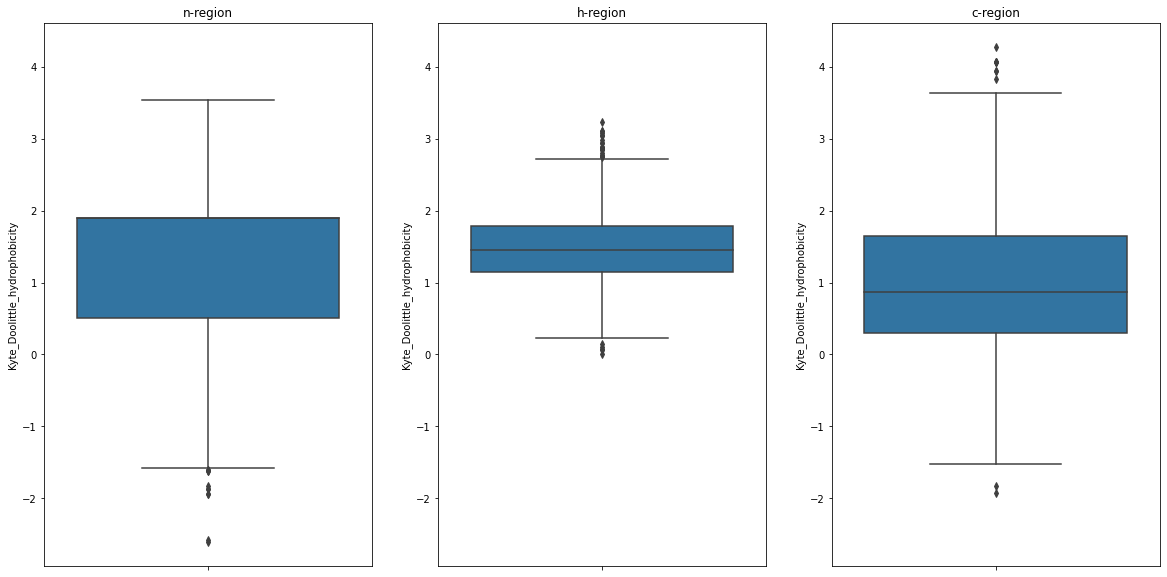

In [36]:
plt.figure(figsize=(20,10))

ax1 = plt.subplot(1,3,1)
ax1 = sns.boxplot(y=n_region["Kyte_Doolittle_hydrophobicity"], orient='vertical')


plt.title('n-region')
ax2 = plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2 = sns.boxplot(y=h_region["Kyte_Doolittle_hydrophobicity"], orient='Vertical')

plt.title('h-region')
ax3 = plt.subplot(1,3,3, sharex=ax1, sharey=ax1)

ax3 = sns.boxplot(y=c_region["Kyte_Doolittle_hydrophobicity"], orient='Vertical')
plt.title('c-region')



### Plotting charge_at_ph 7.6 per regions
The following article mentions that physiological ph is 7.6 for Aspergillus
ref : https://pubmed.ncbi.nlm.nih.gov/12135488/

Text(0.5, 1.0, 'c-region')

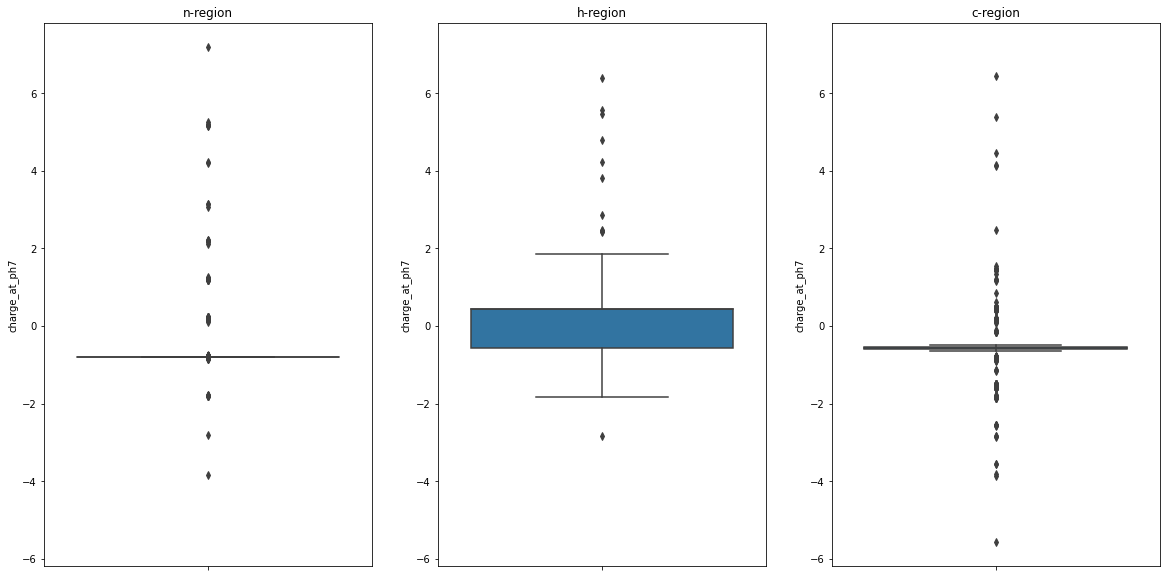

In [37]:
plt.figure(figsize=(20,10))
ax1 = plt.subplot(1,3,1, sharex=ax1, sharey=ax1)
ax1 = sns.boxplot(y=n_region["charge_at_ph7"], orient='vertical')

plt.title('n-region')
ax2 = plt.subplot(1,3,2, sharex=ax1, sharey=ax1)
ax2 = sns.boxplot(y=h_region["charge_at_ph7"], orient='Vertical')

plt.title('h-region')
ax3 = plt.subplot(1,3,3, sharex=ax1, sharey=ax1)

ax3 = sns.boxplot(y=c_region["charge_at_ph7"], orient='Vertical')
plt.title('c-region')

## PWM with signal peptides with all lenghts

Ok, so we know from the statistics above that 460+ signal peptides are exactly 20 amino acids long. We want to train ML algoriths on all sizes of signal peptides so lets try to append dashes to signal peptides that are shorter than the longest signal peptide

In [38]:
longest_signalP = 68

In [39]:
list_of_SPs = list(all_signal_peptides_df['sequence'])

In [40]:
instances = []
for sp in list_of_SPs: 
    instances.append(Seq(add_dunder_tail(sp,longest_signalP)))

In [41]:
instances[:10]

[Seq('MAPSHSFMLFLSVICTHLCSLVV-------------------------------...---'),
 Seq('MHLRNIVIALAATAVASPVDLQD-------------------------------...---'),
 Seq('MKASFISRLLSLTAFAISSNLSY-------------------------------...---'),
 Seq('MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL-------------...---'),
 Seq('MHLQATLAVGLSLLGLTL------------------------------------...---'),
 Seq('MFSTMTPSLSKLVALSLFLGTAL-------------------------------...---'),
 Seq('MRIFSSIFAVANVLSLSTGRVIP-------------------------------...---'),
 Seq('MRSVSLFLWGLAPLLAS-------------------------------------...---'),
 Seq('MKSILYYTSCFIAVLGTVN-----------------------------------...---'),
 Seq('MGRQTPVYRAAQTCILGLVLLSFAS-----------------------------...---')]

In [42]:
from Bio import motifs

m = motifs.create(instances, alphabet="ACDEFGHIKLMNPQRSTVWY-")
m.consensus

Seq('MKLLLLLLLLLLLLAAA-------------------------------------...---')

In [43]:
df = pd.DataFrame(m.counts)
df

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,-
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,74,2,3,2,34,23,68,40,221,90,...,24,31,62,205,36,20,56,16,30,0
2,47,8,7,8,162,50,21,53,20,202,...,23,56,22,57,139,57,64,27,24,0
3,61,2,5,5,95,21,17,68,62,186,...,36,45,46,60,173,106,23,11,28,0
4,77,6,5,8,58,34,21,82,57,165,...,44,43,39,48,147,103,46,25,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1059
64,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1060
65,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1060
66,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1060


In [44]:
# getting the prevalence of each AA on each position 
df_pwn = pd.DataFrame(m.pwm)
df_pwn.to_csv('../data/02_all_signal_peptides/df_pwn_68_positions.csv', index_label=False )
df_pwn

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,-
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.069746,0.001885,0.002828,0.001885,0.032045,0.021678,0.064090,0.037700,0.208294,0.084826,...,0.022620,0.029218,0.058435,0.193214,0.033930,0.018850,0.052780,0.015080,0.028275,0.000000
2,0.044298,0.007540,0.006598,0.007540,0.152686,0.047125,0.019793,0.049953,0.018850,0.190386,...,0.021678,0.052780,0.020735,0.053723,0.131008,0.053723,0.060320,0.025448,0.022620,0.000000
3,0.057493,0.001885,0.004713,0.004713,0.089538,0.019793,0.016023,0.064090,0.058435,0.175306,...,0.033930,0.042413,0.043355,0.056550,0.163054,0.099906,0.021678,0.010368,0.026390,0.000000
4,0.072573,0.005655,0.004713,0.007540,0.054665,0.032045,0.019793,0.077286,0.053723,0.155514,...,0.041470,0.040528,0.036758,0.045240,0.138549,0.097078,0.043355,0.023563,0.032045,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.000943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000943,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.998115
64,0.000943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999057
65,0.000943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999057
66,0.000943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999057


In [45]:
import logomaker as lm

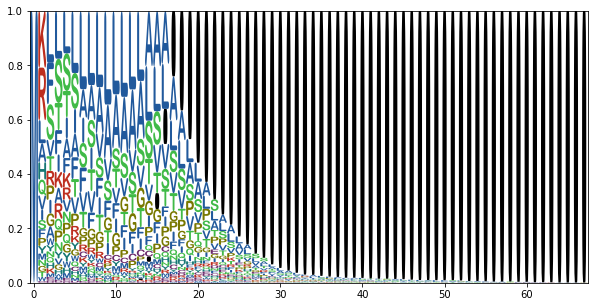

In [46]:
logo = lm.Logo(df_pwn, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='NajafabadiEtAl2017',
               figsize=(10,5))

## PWM of signal peptides found from proteomics data

In [47]:
proteomics_df = pd.read_excel('../data/03_proteomics_data/20221124_FJ_E1200_MWN_15cm_140min_500ng_#1572_proteins.xlsx')
proteomics_df

,Checked,Protein FDR Confidence: Combined,Master,Accession,Description,Exp. q-value: Combined,Sum PEP Score,Coverage [%],# Peptides,# PSMs,...,"Found in Sample: [S23] F23: Sample, 8","Found in Sample: [S24] F24: Sample, 9","Found in Sample: [S25] F25: Sample, 10","Found in Sample: [S26] F26: Sample, 11","Found in Sample: [S27] F27: Sample, 12","Found in Sample: [S28] F28: Sample, 13","Found in Sample: [S29] F29: Sample, 14","Found in Sample: [S30] F30: Sample, 15",# Protein Groups,Modifications
0,False,High,Master Protein,AO090003000935-T-p1,transcript=AO090003000935-T | gene=AO090003000...,0.000,599.687,89,31,7127,...,High,High,High,High,High,High,High,High,1,NaN
1,False,High,Master Protein,AO090023000944-T-p1,transcript=AO090023000944-T | gene=AO090023000...,0.000,523.784,68,32,3237,...,High,High,High,Peak Found,Peak Found,High,High,High,1,NaN
2,False,High,Master Protein,AO090003001591-T-p1,transcript=AO090003001591-T | gene=AO090003001...,0.000,519.742,68,33,2987,...,High,High,Not Found,Not Found,Not Found,High,High,High,1,NaN
3,False,High,Master Protein,RFP_Fusion,RFP_Fusion,0.000,450.464,64,35,398,...,High,Peak Found,High,Peak Found,High,High,High,High,1,NaN
4,False,High,Master Protein,AO090005001300-T-p1,transcript=AO090005001300-T | gene=AO090005001...,0.000,384.472,90,45,554,...,High,High,High,High,High,High,High,High,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
861,False,Medium,Master Protein,AO090001000075-T-p1,transcript=AO090001000075-T | gene=AO090001000...,0.044,1.795,4,1,1,...,Not Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,Peak Found,1,NaN
862,False,Medium,Master Protein,AO090005001355-T-p1,transcript=AO090005001355-T | gene=AO090005001...,0.046,1.790,14,1,1,...,Peak Found,Peak Found,Peak Found,Not Found,Peak Found,Not Found,Peak Found,Not Found,1,NaN
863,False,Medium,Master Protein,AO090003000247-T-p1,transcript=AO090003000247-T | gene=AO090003000...,0.047,1.779,4,1,1,...,Not Found,Peak Found,Peak Found,Peak Found,Peak Found,Not Found,Not Found,Not Found,1,Met-loss [N-Term]
864,False,Medium,Master Protein,AO090001000680-T-p1,transcript=AO090001000680-T | gene=AO090001000...,0.048,1.774,1,1,1,...,Not Found,Not Found,Peak Found,Peak Found,Not Found,Peak Found,High,Peak Found,1,NaN


In [48]:
pure_peptides = merged.drop_duplicates(subset=['gene'])
pure_peptides

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence,start_pos_region,end_pos_region,region,region_seq,Kyte_Doolittle_hydrophobicity,charge_at_ph7
0,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV,0,3,n-region,MAP,0.700,-0.799151
3,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD,0,1,n-region,M,1.900,-0.799151
6,AO090005000042-T-p1,0,23,0.99984324,MKASFISRLLSLTAFAISSNLSY,0,1,n-region,M,1.900,-0.799151
9,AO090005000053-T-p1,0,41,0.8548089,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL,0,25,n-region,MGLFLTALGALSSVNVLYSRGRMPL,0.868,1.196804
12,AO090005000059-T-p1,0,18,0.9998212,MHLQATLAVGLSLLGLTL,0,1,n-region,M,1.900,-0.799151
...,...,...,...,...,...,...,...,...,...,...,...
3168,AO090103000483-T-p1,0,19,0.83310604,MKTSFLLAAIGFLYRLPCS,0,2,n-region,MK,-1.000,0.196884
3171,AO090103000487-T-p1,0,19,0.99971014,MTRYLSFLFLLILFGNSVF,0,2,n-region,MT,0.600,-0.799151
3174,AO090103000493-T-p1,0,17,0.99979144,MRGIVALSFLSVALGVT,0,1,n-region,M,1.900,-0.799151
3177,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ,0,1,n-region,M,1.900,-0.799151


In [49]:
list_of_proteins_found_in_supernatant = proteomics_df['Accession'].to_list()

In [50]:
predicted_SPs = all_signal_peptides_df['gene'].to_list()

In [51]:
list_of_acc_real_signal_peptides = []
for signal_peptide in predicted_SPs: 
    if signal_peptide in list_of_proteins_found_in_supernatant: 
        list_of_acc_real_signal_peptides.append(signal_peptide)
print(len(list_of_acc_real_signal_peptides))

256


In [52]:
sequence_SPs_real = []
for index, row in pure_peptides.iterrows():
    if row['gene'] in list_of_acc_real_signal_peptides: 
        sequence_SPs_real.append(row['sequence'])
print(len(sequence_SPs_real))

256


what is the longest observed signal peptide? 

In [53]:
res = max(sequence_SPs_real, key = len)
len(res)

68

In [54]:
longest_signalP = int(len(res))

In [55]:
instances = []
for sp in sequence_SPs_real: 
    instances.append(Seq(add_dunder_tail(sp,longest_signalP)))

In [56]:
m = motifs.create(instances, alphabet="ACDEFGHIKLMNPQRSTVWY-")
m.consensus

Seq('MKLSSLLLLLLLLLAAA-------------------------------------...---')

In [57]:
df_pwn = pd.DataFrame(m.pwm)
df_pwn

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,-
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.070312,0.000000,0.003906,0.003906,0.035156,0.000000,0.062500,0.035156,0.234375,0.078125,...,0.011719,0.031250,0.070312,0.214844,0.031250,0.007812,0.046875,0.015625,0.015625,0.000000
2,0.042969,0.000000,0.003906,0.007812,0.179688,0.058594,0.000000,0.050781,0.015625,0.210938,...,0.023438,0.027344,0.023438,0.066406,0.140625,0.050781,0.066406,0.007812,0.015625,0.000000
3,0.070312,0.000000,0.003906,0.000000,0.097656,0.035156,0.015625,0.046875,0.062500,0.167969,...,0.031250,0.042969,0.058594,0.042969,0.179688,0.085938,0.015625,0.011719,0.019531,0.000000
4,0.109375,0.007812,0.007812,0.007812,0.035156,0.027344,0.015625,0.066406,0.066406,0.136719,...,0.046875,0.035156,0.046875,0.015625,0.167969,0.078125,0.046875,0.019531,0.046875,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,0.003906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003906,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.992188
64,0.003906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996094
65,0.003906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996094
66,0.003906,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996094


In [58]:
df_pwn.to_csv('../data/02_all_signal_peptides/df_pwn_for_signal_peptides_found_in_supernatant.csv', index = False)

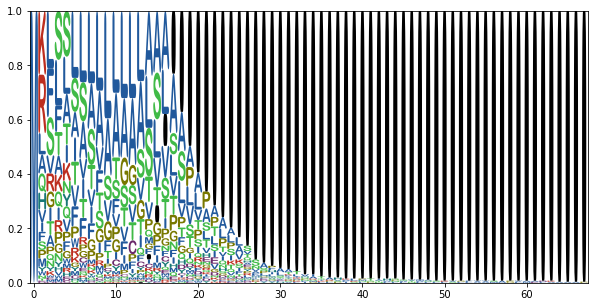

In [59]:
logo = lm.Logo(df_pwn, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='NajafabadiEtAl2017',
               figsize=(10,5))

We migth want to limit the length to around 30 so lets make another df

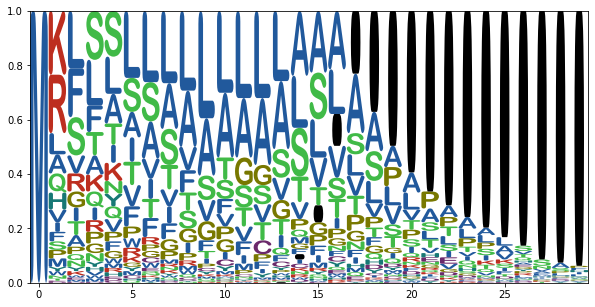

In [60]:
df_pwn_30 = df_pwn[0:30]
logo = lm.Logo(df_pwn_30, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='NajafabadiEtAl2017',
               figsize=(10,5))

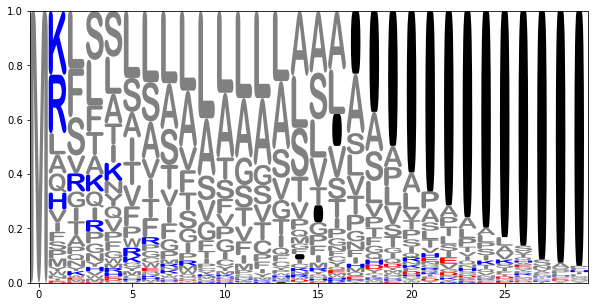

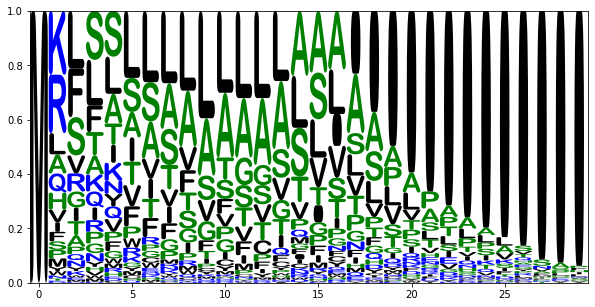

In [61]:
#### We can color for charge and hydrophobicity

df_pwn_30 = df_pwn[0:30]
logo = lm.Logo(df_pwn_30, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='charge',
               figsize=(10,5))

df_pwn_30 = df_pwn[0:30]
logo = lm.Logo(df_pwn_30, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='hydrophobicity',
               figsize=(10,5))

# Removing SPs that are aboave 30 and 22 in length

### 30 AAs

In [62]:
SPs_30 = all_signal_peptides_df[(all_signal_peptides_df[['end_pos']]<31).all(axis=1)]
SPs_30

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence
0,AO090005000016-T-p1,0,23,0.99980325,MAPSHSFMLFLSVICTHLCSLVV
1,AO090005000029-T-p1,0,23,0.99983543,MHLRNIVIALAATAVASPVDLQD
2,AO090005000042-T-p1,0,23,0.99984324,MKASFISRLLSLTAFAISSNLSY
4,AO090005000059-T-p1,0,18,0.9998212,MHLQATLAVGLSLLGLTL
5,AO090005000064-T-p1,0,23,0.99979186,MFSTMTPSLSKLVALSLFLGTAL
...,...,...,...,...,...
196,AO090103000483-T-p1,0,19,0.83310604,MKTSFLLAAIGFLYRLPCS
197,AO090103000487-T-p1,0,19,0.99971014,MTRYLSFLFLLILFGNSVF
198,AO090103000493-T-p1,0,17,0.99979144,MRGIVALSFLSVALGVT
199,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ


In [63]:
sequence_SPs_real_30 = list(SPs_30['sequence'])

In [64]:
instances = []
for sp in sequence_SPs_real_30: 
    instances.append(Seq(add_dunder_tail(sp,30)))

In [65]:
m = motifs.create(instances, alphabet="ACDEFGHIKLMNPQRSTVWY-")
m.consensus

Seq('MKLLLLLLLLLLLLAAA-------------')

In [66]:
df_pwn = pd.DataFrame(m.pwm)
df_pwn

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,-
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.067797,0.001994,0.001994,0.000997,0.032901,0.016949,0.063809,0.038883,0.210369,0.086740,...,0.020937,0.026919,0.058824,0.202393,0.032901,0.017946,0.049850,0.014955,0.028913,0.000000
2,0.046859,0.007976,0.005982,0.006979,0.157527,0.044865,0.018943,0.048853,0.014955,0.195414,...,0.018943,0.050847,0.020937,0.050847,0.132602,0.055833,0.061815,0.026919,0.021934,0.000000
3,0.058824,0.001994,0.002991,0.003988,0.086740,0.017946,0.015952,0.063809,0.057827,0.180459,...,0.032901,0.042871,0.043868,0.054835,0.167498,0.102692,0.017946,0.009970,0.026919,0.000000
4,0.074776,0.004985,0.003988,0.007976,0.051844,0.031904,0.019940,0.076770,0.053838,0.157527,...,0.041874,0.039880,0.036889,0.045862,0.138584,0.093719,0.044865,0.024925,0.031904,0.000000
5,0.087737,0.013958,0.003988,0.000997,0.079761,0.023928,0.013958,0.093719,0.021934,0.235294,...,0.011964,0.043868,0.017946,0.033898,0.130608,0.065803,0.061815,0.022931,0.025922,0.000000
6,0.102692,0.018943,0.000997,0.004985,0.094716,0.030907,0.007976,0.092722,0.016949,0.294118,...,0.005982,0.029910,0.008973,0.020937,0.092722,0.058824,0.074776,0.011964,0.015952,0.000000
7,0.131605,0.007976,0.003988,0.002991,0.059821,0.035892,0.008973,0.080758,0.011964,0.277168,...,0.007976,0.030907,0.010967,0.023928,0.105683,0.079761,0.079761,0.017946,0.012961,0.000000
8,0.173480,0.016949,0.001994,0.003988,0.071785,0.038883,0.005982,0.065803,0.004985,0.285145,...,0.004985,0.031904,0.009970,0.021934,0.076770,0.060818,0.088734,0.016949,0.006979,0.000000
9,0.200399,0.017946,0.000997,0.000000,0.063809,0.045862,0.002991,0.045862,0.002991,0.353938,...,0.004985,0.013958,0.007976,0.012961,0.072782,0.047856,0.079761,0.007976,0.008973,0.000000


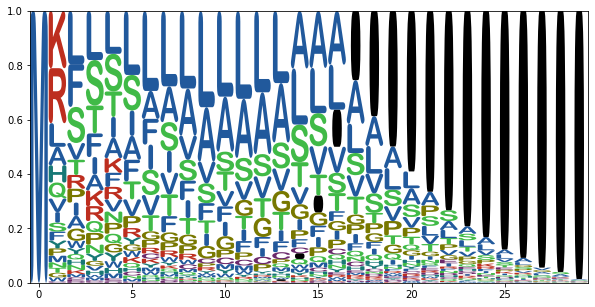

In [67]:
logo = lm.Logo(df_pwn, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='NajafabadiEtAl2017',
               figsize=(10,5))

### 22 AAs

In [68]:
SPs_22 = all_signal_peptides_df[(all_signal_peptides_df[['end_pos']]<23).all(axis=1)]
SPs_22

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence
4,AO090005000059-T-p1,0,18,0.9998212,MHLQATLAVGLSLLGLTL
7,AO090005000067-T-p1,0,17,0.99984986,MRSVSLFLWGLAPLLAS
8,AO090005000078-T-p1,0,19,0.99980634,MKSILYYTSCFIAVLGTVN
10,AO090005000093-T-p1,0,21,0.9998531,MILPQGLLFFVSLAACSTAVV
12,AO090005000108-T-p1,0,17,0.99980265,MHLSSFSLLALGAATAN
...,...,...,...,...,...
196,AO090103000483-T-p1,0,19,0.83310604,MKTSFLLAAIGFLYRLPCS
197,AO090103000487-T-p1,0,19,0.99971014,MTRYLSFLFLLILFGNSVF
198,AO090103000493-T-p1,0,17,0.99979144,MRGIVALSFLSVALGVT
199,AO090701000994-T-p1,0,18,0.99984515,MRLLLIAPLFSAVSYGAQ


In [69]:
sequence_SPs_real_22 = list(SPs_22['sequence'])

In [70]:
instances = []
for sp in sequence_SPs_real_22: 
    instances.append(Seq(add_dunder_tail(sp,22)))

In [71]:
m = motifs.create(instances, alphabet="ACDEFGHIKLMNPQRSTVWY-")
m.consensus

Seq('MKLLLLLLLLLLLLAA------')

In [72]:
df_pwn = pd.DataFrame(m.pwm)
df_pwn

,A,C,D,E,F,G,H,I,K,L,...,N,P,Q,R,S,T,V,W,Y,-
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.051701,0.000000,0.001361,0.000000,0.034014,0.016327,0.058503,0.038095,0.213605,0.102041,...,0.023129,0.025850,0.065306,0.212245,0.024490,0.019048,0.040816,0.016327,0.032653,0.000000
2,0.040816,0.008163,0.001361,0.002721,0.170068,0.038095,0.014966,0.047619,0.016327,0.202721,...,0.014966,0.053061,0.021769,0.055782,0.129252,0.054422,0.066667,0.031293,0.023129,0.000000
3,0.061224,0.001361,0.000000,0.002721,0.078912,0.013605,0.016327,0.070748,0.058503,0.179592,...,0.031293,0.046259,0.046259,0.053061,0.164626,0.104762,0.023129,0.012245,0.027211,0.000000
4,0.084354,0.006803,0.002721,0.006803,0.048980,0.035374,0.020408,0.080272,0.050340,0.167347,...,0.034014,0.038095,0.035374,0.036735,0.134694,0.089796,0.048980,0.028571,0.034014,0.000000
5,0.092517,0.013605,0.002721,0.000000,0.089796,0.020408,0.012245,0.099320,0.013605,0.251701,...,0.010884,0.038095,0.012245,0.029932,0.129252,0.058503,0.069388,0.023129,0.027211,0.000000
6,0.112925,0.013605,0.000000,0.005442,0.096599,0.024490,0.008163,0.103401,0.010884,0.311565,...,0.008163,0.025850,0.006803,0.010884,0.082993,0.063946,0.074830,0.009524,0.016327,0.000000
7,0.155102,0.009524,0.001361,0.001361,0.059864,0.040816,0.008163,0.087075,0.006803,0.291156,...,0.005442,0.028571,0.004082,0.010884,0.102041,0.072109,0.080272,0.017687,0.010884,0.000000
8,0.180952,0.014966,0.000000,0.000000,0.074830,0.042177,0.002721,0.062585,0.001361,0.307483,...,0.002721,0.028571,0.006803,0.009524,0.073469,0.065306,0.096599,0.016327,0.005442,0.000000
9,0.206803,0.017687,0.000000,0.000000,0.069388,0.040816,0.002721,0.048980,0.004082,0.375510,...,0.002721,0.010884,0.002721,0.001361,0.074830,0.042177,0.081633,0.004082,0.008163,0.000000


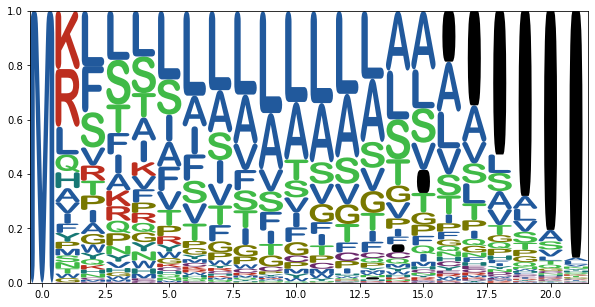

In [73]:
logo = lm.Logo(df_pwn, 
               font_name = 'Arial Rounded MT Bold',
               color_scheme='NajafabadiEtAl2017',
               figsize=(10,5))

# Combinatorial explosion

In order to engineer signal peptides, a prediction table must be generated to identify the specific amino acid sequences that are most likely to function as signal peptides. However, the number of possible combinations of the 20 amino acids that make up proteins is extremely large. For example, if a signal peptide consists of just 20 amino acids, there are 20^20 (or approximately 2 x 10^13) possible combinations. This large number of possibilities makes it difficult to predict which sequences will function as signal peptides and which will not. To overcome this challenge, computational methods must be applied. In the next notbook we well show such a method with the use of machine learning. 

An example of how quickly this happens is visualized below:

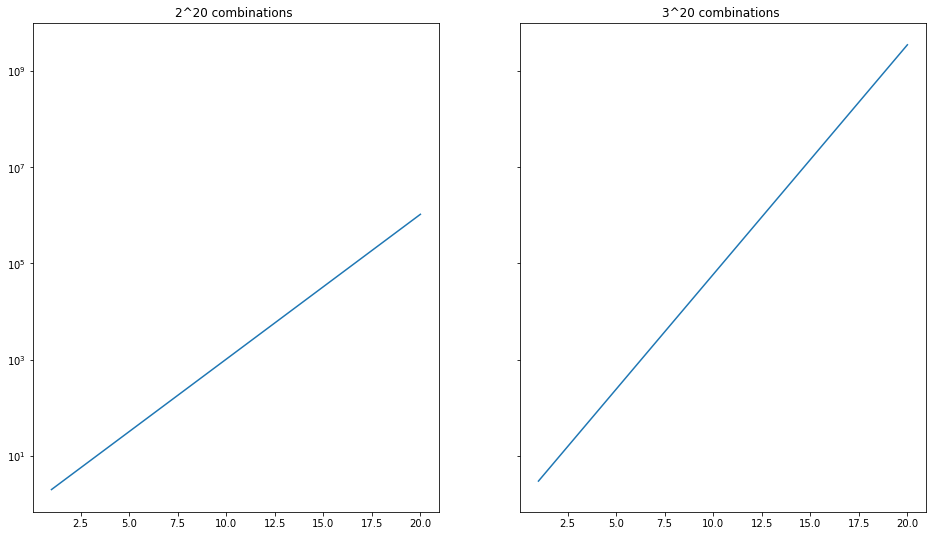

In [74]:
import matplotlib.pyplot as plt

## Generating 3^20 combinations 
data_points1 = []
index1 = []

for i in range(1,21): 
    data_points1.append(2**i)
    index1.append(i)
    
## Generating 2^20 combinations 
data_points2 = []
index2 = []
for i in range(1,21): 
    data_points2.append(3**i)
    index2.append(i)

# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,9))

ax1.plot(index1, data_points1)
ax1.set_title('2^20 combinations ')
ax2.plot(index2,data_points2)
ax2.set_title('3^20 combinations ')
plt.yscale("log")


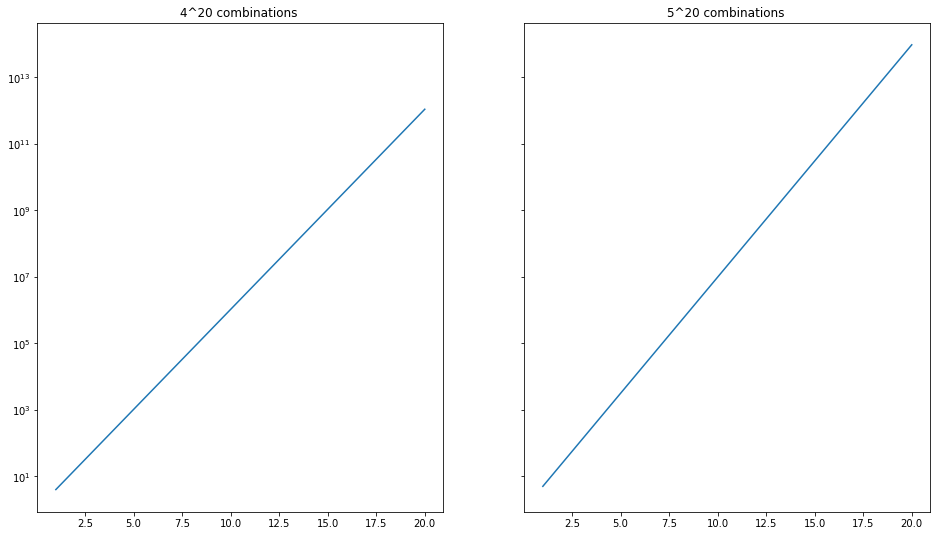

In [75]:
import matplotlib.pyplot as plt

## Generating 3^20 combinations 
data_points1 = []
index1 = []

for i in range(1,21): 
    data_points1.append(4**i)
    index1.append(i)
    
## Generating 2^20 combinations 
data_points2 = []
index2 = []
for i in range(1,21): 
    data_points2.append(5**i)
    index2.append(i)

# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,9))

ax1.plot(index1, data_points1)
ax1.set_title('4^20 combinations ')
ax2.plot(index2,data_points2)
ax2.set_title('5^20 combinations ')
plt.yscale("log")

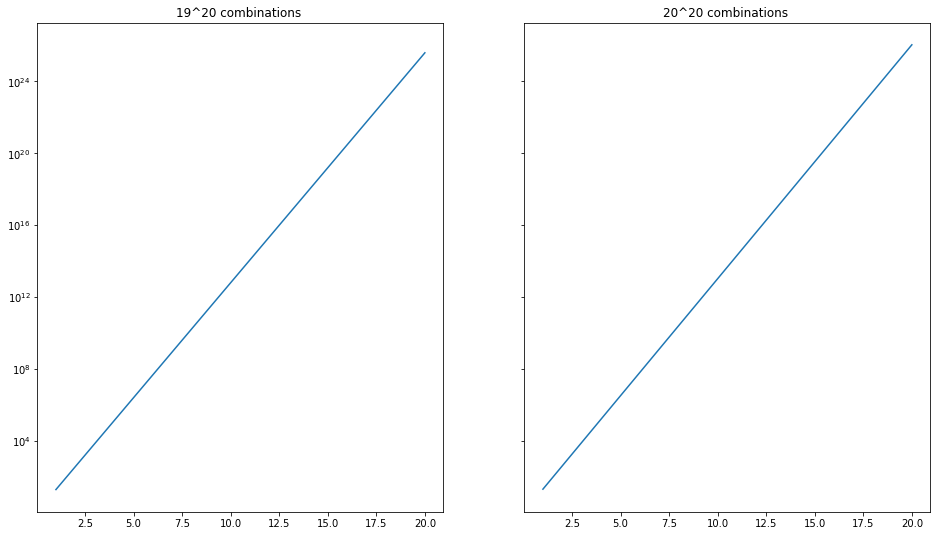

In [76]:
import matplotlib.pyplot as plt

## Generating 3^20 combinations 
data_points1 = []
index1 = []

for i in range(1,21): 
    data_points1.append(19**i)
    index1.append(i)
    
## Generating 2^20 combinations 
data_points2 = []
index2 = []
for i in range(1,21): 
    data_points2.append(20**i)
    index2.append(i)

# Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,9))

ax1.plot(index1, data_points1)
ax1.set_title('19^20 combinations ')
ax2.plot(index2,data_points2)
ax2.set_title('20^20 combinations ')
plt.yscale("log")